
# Discover Cost-Efficient AI Customer Service Agents with NVIDIA Data Flywheel Blueprint
[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://brev.nvidia.com/launchable/deploy?launchableID=env-2wggjBvDlVp4pLQD8ytZySh5m8W)

In this notebook, you will learn how to use the Data Flywheel Blueprint to continuously discover and promote more cost-efficient agents for an [AI virtual customer service assistant](https://build.nvidia.com/nvidia/ai-virtual-assistant-for-customer-service).

### Data Flywheel Blueprint

![Data Flywheel Blueprint](https://raw.githubusercontent.com/NVIDIA-AI-Blueprints/data-flywheel/update-launchable/docs/images/data-flywheel-blueprint.png)


### AI Virtual Assistant for Customer Service

The primary customer service agent in the AI Virtual Assistant uses tool calling to route user queries to specialized assistants, including: 

- Product Q&A
- Order status verification
- Returns processing
- Small talk and casual engagement

These interactions generate logs and tool-calling data that you can use as both evaluation benchmarks and training data. In this tutorial, you'll use this information to drive the flywheel process, fine-tuning smaller LLMs (such as `meta/llama-3.2-1B-instruct`, `meta/llama-3.2-3B-instruct`, `meta/llama-3.1-8B-instruct`) to match accuracy of the currently deployed model (`meta/llama-3.3-70B-instruct`).

## Interfacing with the Blueprint

The following diagram illustrates how admin tools and applications interact with the Data Flywheel Blueprint, which orchestrates logging, processing, and model management to enable continuous optimization.

![Arch](https://raw.githubusercontent.com/NVIDIA-AI-Blueprints/data-flywheel/main/notebooks/arch.png)

### Contents 

0. [Data Flywheel Setup](#0)
1. [Load Sample Data](#1)
2. [Create a Flywheel Job](#2)
3. [Monitor Job Status](#3)
4. [Optional: Show Continuous Improvement](#4)

---

<a id="0"></a>
## Data Flywheel Setup

**Step 1**: Set NGC API key following the instructions at [Generating NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-private-registry-user-guide/index.html#generating-api-key).

**When creating the key, make sure Public API Enpoints are included in the services.**

In [1]:
import os
from getpass import getpass

os.environ['NGC_API_KEY'] = getpass("Enter your NGC API Key")

Enter your NGC API Key ········


**Step 2**: Clone the data flywheel repo and fetch data files.

This step presents two options:
* **Step 2 (Option 1) NVIDIA Brev Launchable Setup:** The instructions below apply **only** to users running this notebook via the Brev Launchable.
  
NVIDIA Brev is a developer-friendly platform that makes it easy to run, train, and deploy ML models on cloud GPUs without the hassle of setup—it comes preloaded with Python, CUDA, and Docker so you can get started fast.

In [2]:
%%bash
git clone https://github.com/NVIDIA-AI-Blueprints/data-flywheel.git
cd data-flywheel
sudo apt-get update && sudo apt-get install -y git-lfs
git lfs install
git-lfs pull

In [3]:
from pathlib import Path

notebook_dir = Path.cwd()
project_root = notebook_dir / "data-flywheel"
local_bin = os.path.expanduser("~/.local/bin")
os.environ["PATH"] = f"{local_bin}:{os.environ['PATH']}"
print(f"Updated PATH to include: {local_bin}")

Updated PATH to include: /home/ubuntu/.local/bin


* **Step 2 (Option 2) Self-Hosted Notebook Setup:** The instructions below apply **only** to users running this notebook on their own setup (i.e., if you followed the pre-requisites in the [Data-Flywheel Blueprint Github README](https://github.com/NVIDIA-AI-Blueprints/data-flywheel/tree/main/notebooks#prerequisites) for hardware and software requirements, to clone the repo, and start Jupyter Notebook.)

    > **Note:** If you are using a Brev Launchable, please follow **Option 1** above in this step.

In [4]:
## Important: Uncomment and run this cell in a self-hosted notebook setup

# from pathlib import Path

# notebook_dir = Path.cwd()
# project_root = notebook_dir.parent

**Step 3**: Set up paths and install python dependencies for notebook.

In [ ]:
import sys

data_dir = project_root / "data"
sys.path.insert(0, str(project_root))
os.chdir(project_root)
print(f"Working directory changed to: {Path.cwd()}")

user_site = Path.home() / ".local" / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
if str(user_site) not in sys.path:
    sys.path.append(str(user_site))
    print(f"Added user site-packages to sys.path: {user_site}")

%pip install --user elasticsearch==8.17.2 pandas>=2.2.3 matplotlib==3.10.3 pydantic==2.11.3 pydantic-settings==2.9.1

Working directory changed to: /home/ubuntu/data-flywheel
Added user site-packages to sys.path: /home/ubuntu/.local/lib/python3.10/site-packages
Note: you may need to restart the kernel to use updated packages.


**Step 4**: Update `config/config.yaml` to use remote LLM as judge. By default, the Data Flywheel Blueprint deploys `LLama-3.3-70B-instruct` locally for LLM as a judge, which requires 4 GPUs. But for the launchable, we will choose the remote LLM judge and use the `LLama-3.1-70B-instruct` NIM hosted on [build.nvidia.com](https://build.nvidia.com/meta/llama-3_3-70b-instruct).

By default, only `Llama-3.2-1b-instruct` will be used in the flywheel but you can uncomment other models in the yaml file to include in the flywheel run. You can also change other config settings such as data split and training hyperparameters as desired.



In [5]:
import re
from textwrap import dedent

config_path = project_root / "config" / "config.yaml"

new_llm_block = dedent("""\
llm_judge_config:
  deployment_type: "remote"
  url: "https://integrate.api.nvidia.com/v1/chat/completions"
  model_name: "meta/llama-3.1-70b-instruct"

""")

new_nims_block = dedent("""\
nims:
  - model_name: "meta/llama-3.2-1b-instruct"
    model_type: "llm"
    context_length: 8192
    gpus: 1
    pvc_size: 25Gi
    tag: "1.8.3"
    customization_enabled: true
    customizer_configs:
      target: "meta/llama-3.2-1b-instruct@2.0"
      gpus: 1
      max_seq_length: 8192


  - model_name: "meta/llama-3.2-3b-instruct"
    model_type: "llm"
    context_length: 8192
    gpus: 1
    pvc_size: 25Gi
    tag: "1.8.3"
    customization_enabled: true
    customizer_configs:
      target: "meta/llama-3.2-3b-instruct@2.0"
      gpus: 1
      max_seq_length: 8192


  - model_name: "meta/llama-3.1-8b-instruct"
    model_type: "llm"
    context_length: 8192
    gpus: 1
    pvc_size: 25Gi
    tag: "1.8.3"
    customization_enabled: true
    customizer_configs:
      target: "meta/llama-3.1-8b-instruct@2.0"
      gpus: 1
      max_seq_length: 8192


""")

text = config_path.read_text()

def replace_block(yaml_text: str, key: str, new_block: str) -> str:
    pattern = rf"(?ms)^({re.escape(key)}:[\s\S]*?)(?=^\S|\Z)"
    return re.sub(pattern, new_block, yaml_text)

text = replace_block(text, "llm_judge_config", new_llm_block)
text = replace_block(text, "nims",              new_nims_block)

config_path.write_text(text)
print("config.yaml updated")

config.yaml updated


To use remote LLM as judge, we will set the API key to access the remote LLM. You can create an API Key at https://build.nvidia.com/settings/api-keys.

In [6]:
os.environ['NVIDIA_API_KEY'] = getpass("Enter your NVIDIA API Key")

Enter your NVIDIA API Key ········


**Step 5**: Start data flywheel service, which involves first deploying the Nemo Microservices and then bring up the data flywheel service via docker compose with MLFlow enabled. This step may take about 10 minutes.

> **Note:** The `deploy-nmp.sh` script automates the deployment of NeMo Microservices. For manual setup or advanced configuration, please consult the [NeMo Microservices documentation](https://docs.nvidia.com/nemo/microservices/latest/get-started/platform-prereq.html#beginner-tutorial-prerequisites).

If you choose to manually deploy the Nemo Microservices Platform, then make sure you update the `nmp_config` field in the `config/config.yaml` with the correct base urls. The default is:
```
nmp_config:
      nemo_base_url: "http://nemo.test"
      nim_base_url: "http://nim.test"
      datastore_base_url: "http://data-store.test"
```

In [7]:
%%bash
set -e

log() {
  echo -e "\033[1;32m[INFO]\033[0m $1"
}

echo "$NGC_API_KEY" | docker login nvcr.io -u '$oauthtoken' --password-stdin
chmod +x scripts/deploy-nmp.sh
./scripts/deploy-nmp.sh --progress
log "Starting data flywheel service..."
export COMPOSE_PROFILES=mlflow && docker compose -f deploy/docker-compose.yaml up -d --build >> flywheel_deploy.log 2>&1
log "Data flywheel service started successfully!"


WARNING! Your credentials are stored unencrypted in '/home/ubuntu/.docker/config.json'.
Configure a credential helper to remove this warning. See
https://docs.docker.com/go/credential-store/



Login Succeeded
[INFO] Starting NeMo Microservices deployment...
[INFO] Detailed logs will be written to: /tmp/nemo-deploy.log

[INFO] Step 1/8: Checking prerequisites [██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░���] 12%
[INFO] Step 2/8: Downloading Helm chart [████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░���] 25%
[INFO] Step 3/8: Starting Minikube [█████████████████��░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 37%
[INFO] Step 4/8: Setting up NGC and Helm [███████████████��█████████░░░░░░░░░░░░░░░░░░░░░░░░░] 50%
[INFO] Step 5/8: Installing NeMo microservices [█████████████��█████████████████░░░░░░░░░░░░░░░░░░░] 62%
[INFO] Step 6/8: Waiting for pods [█████████████████████████████████████░░░░░░░░░░░░░] 75%
[INFO] Step 7/8: Checking pod health [███████████████████████████████████████████░░░░░░░] 87%
[INFO] Step 8/8: Configuring DNS [██████████████████���███████████████████████████████] 100%
[INFO] Deployment completed successfully! ✅
[INFO] Starting data flywheel service...
[INFO] Data fl

---

<a id="1"></a>
## Step 1: Load Sample Data


First, we need to import required libraries and configure pandas display options for better readability in notebook outputs.

In [8]:
import sys
from pathlib import Path
import requests
import time
from datetime import datetime
import json
import pandas as pd
from IPython.display import display, clear_output

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Width of the display in characters
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

Use the provided sample dataset from AI Virtual Assistant (`aiva`) (`data/aiva_primary_assistant_dataset.jsonl`) to simulate real user logs captured while an agentic customer service agent application is running. Each data point has the following schema:

| Field        | Type               | Description                                                         |
|--------------|--------------------|---------------------------------------------------------------------|
| `timestamp`  | `int` (epoch secs) | Time the request was issued                                         |
| `workload_id`| `str`              | Stable identifier for the logical task / route / agent node         |
| `client_id`  | `str`              | Identifier of the application or deployment that generated traffic  |
| `request`    | `dict`             | Exact [`openai.ChatCompletion.create`](https://platform.openai.com/docs/api-reference/chat/create) payload received by the model |
| `response`   | `dict`             | Exact `ChatCompletion` response returned by the model               |

The `request` uses the OpenAI `ChatCompletions` request format and contains the following attributes:

- `model` includes the Model ID used to generate the response.
- `messages` includes a `system` message as well as a `user` query.
- `tools` includes a list of functions and parameters available to the LLM to choose from, as well as their parameters and descriptions.

In [9]:
DATA_PATH = data_dir / "aiva_primary_assistant_dataset.jsonl"

!head -n1 {DATA_PATH} | jq

{
  "request": {
    "model": "meta/llama-3.3-70b-instruct",
    "messages": [
      {
        "role": "system",
        "content": "You are a helpful customer support assistant for NVIDIA Gear Store. \nYour primary role is to assist the user to answer customer queries. \nIf a customer asks about his products, his order status, or queries related to processing return, \ndelegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself. \nOnly the specialized assistants are given permission to do this for the user.\nProvide detailed information to the customer, and always double-check the database before concluding that information is unavailable. \nThe user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. \nWhen searching, be persistent. Expand your query bounds if the first search returns no results. \nIf a search comes up emp

The data points generated by AI Virtual Assistant in response to user queries are considered **ground truth**. 

Ground truth data points are used to **evaluate** and **customize** more efficient models that can perform similarly to the current model. This customization process is analogous to a student-teacher distillation setup, where synthetic data generated from the teacher model is used to fine-tune a student model.

Next, we'll load the data into Elasticsearch using a helper method `load_data_to_elasticsearch`, making it accessible to the Data Flywheel service.

In [10]:
from src.scripts.load_test_data import load_data_to_elasticsearch

load_data_to_elasticsearch(file_path=DATA_PATH)

Elasticsearch is ready! Status: green
Elasticsearch is ready! Status: green
Creating primary index: flywheel...
Creating primary index: flywheel...
Document is already in the log format. Loading with overrides.
Data loaded successfully.


---

<a id="2"></a>
## Step 2: Create a Flywheel Job

Initiate a Flywheel job by sending a POST request to the `/jobs` API. This triggers the workflow asynchronously.

In production environments, you can automate this process to run at scheduled intervals, in response to specific events, or on demand.

For this tutorial, we will target the primary customer service agent by setting the `workload_id` to "primary_assistant" and we will set `client_id` to "aiva-1" which has 300 data points.

In [11]:
# Flywheel Service URL
API_BASE_URL = "http://localhost:8000"

response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={"workload_id": "primary_assistant", "client_id": "aiva-1"}
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 6895878cfa822fe01746ca7a


For each candidate model, the data flywheel runs evaluations on the base model and its in-context learning (ICL) variant. If customization is enabled, the model is fine-tuned and evaluated again.

---

<a id="3"></a>
## Step 3: Monitor Job Status

Submit a GET request to `/jobs/{job_id}` to retrieve the current status.

In [12]:
def get_job_status(job_id):
    """Get the current status of a job."""
    response = requests.get(f"{API_BASE_URL}/api/jobs/{job_id}")
    response.raise_for_status()
    return response.json()

In [13]:
get_job_status(job_id)

{'id': '6895878cfa822fe01746ca7a',
 'workload_id': 'primary_assistant',
 'client_id': 'aiva-1',
 'status': 'running',
 'started_at': '2025-08-08T05:13:48.009000',
 'finished_at': None,
 'num_records': 0,
 'llm_judge': {'model_name': 'meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'pending',
   'deployment_status': 'pending',
   'runtime_seconds': 0.0,
   'evaluations': [],
   'customizations': [],
   'error': None},
  {'model_name': 'meta/llama-3.2-3b-instruct',
   'status': 'pending',
   'deployment_status': 'pending',
   'runtime_seconds': 0.0,
   'evaluations': [],
   'customizations': [],
   'error': None},
  {'model_name': 'meta/llama-3.1-8b-instruct',
   'status': 'pending',
   'deployment_status': 'pending',
   'runtime_seconds': 0.0,
   'evaluations': [],
   'customizations': [],
   'error': None}],
 'datasets': [],
 'error': None}

In the job status output, you will see the following metrics for evaluating the accuracy of tool calling once evaluations get completed:

| Metric Name                                   | Definition                                                                                                         | Scoring Criteria                                                                                                         | Notes                                                                                                                        |
|------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| **Function name accuracy**                         | Checks if the predicted function name exactly matches the ground truth function name.                              | 1 if predicted function name is an exact match; 0 otherwise.                                                             | Evaluates only the function name, not arguments.                                                                             |
| **Function name + args accuracy (exact-match)**  | Checks if both the function name and all arguments exactly match the ground truth.                                  | 1 if both function name and all arguments are exact matches; 0 otherwise.                                                | Strictest metric; all parts must match exactly.                                                                              |
| **Function name + args accuracy (LLM-judge)**    | Checks if the function name matches exactly, and arguments are either exact matches or semantically equivalent.     | 1 if function name matches and each argument is either an exact match or semantically correct (as judged by an LLM); 0 otherwise. | Allows semantic similarity for complex arguments; captures intent and functional correctness even with paraphrasing.          |

To simplify the process and enable continuous monitoring, we defined a utility function `monitor_job` in `utils/job_monitor_helper.py`:

- Periodically retrieve the job status
- Format the output into a table
- When any evaluations get completed, it fetches detailed results from the NeMo Evaluator Microservice, and uploads them to MLflow for visualization.

This makes it easier to compare and analyze the results. 

### (Optional) Viewing the MLflow dashboard
If MLflow visualization is enabled, the MLflow dashboard will be available at port 5000 (default)
* **If using Brev Launchable:**
    Navigate to your Brev instance page, go to the `Access` tab, select `Using Secure Links`, and click the link that looks like `https://mlflow-*.brevlab.com`. As evaluation jobs complete, they will be logged in MLflow with their flywheel `job_id` as the MLflow experiment name.
* **If using a Self-Hosted Notebook Setup:**
    Open your browser and go to `<local-IP>:5000`

### Run Continuous Monitoring

> **Note:** The first customization run typically takes about **10 minutes** to start while the training container is being downloaded. The `monitor_job` call in the cell below usually requires around **50 minutes** to complete training and evaluation of the candidate NIMs, though the exact duration may vary depending on the specific GPU and the responsiveness of the remote endpoint used for LLM-judge evaluations.  
>  
> As the evaluations complete, you will begin to see metrics appear in both the table and the MLflow dashboard.

Job Status: completed
Total Records: 300
Last Updated: 06:20:56

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,Function name accuracy,Function name + args accuracy (exact-match),Function name + args accuracy (LLM-judge)
6,meta/llama-3.1-8b-instruct,BASE-EVAL,100.0,8m 17s,Completed,06:04:27,06:12:44,0.90,0.00,0.61
8,meta/llama-3.1-8b-instruct,CUSTOMIZED-EVAL,100.0,6m 52s,Completed,06:12:59,06:19:50,0.97,0.06,0.76
7,meta/llama-3.1-8b-instruct,ICL-EVAL,100.0,8m 27s,Completed,06:04:27,06:12:54,0.98,0.06,0.78
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,8m 8s,Completed,05:21:51,05:29:58,0.63,0.00,0.33
2,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,5m 47s,Completed,05:37:53,05:43:39,0.77,0.00,0.41
1,meta/llama-3.2-1b-instruct,ICL-EVAL,100.0,7m 13s,Completed,05:21:51,05:29:03,0.74,0.03,0.49
3,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,7m 7s,Completed,05:47:17,05:54:23,0.92,0.01,0.63
5,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,6m 12s,Completed,05:54:18,06:00:29,0.91,0.01,0.54
4,meta/llama-3.2-3b-instruct,ICL-EVAL,100.0,7m 42s,Completed,05:47:17,05:54:58,0.88,0.03,0.58



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
2,meta/llama-3.1-8b-instruct,06:04:27,2,24,06:12:59,Completed,8m 31s,100.0
0,meta/llama-3.2-1b-instruct,05:21:51,2,24,05:37:53,Completed,16m 1s,100.0
1,meta/llama-3.2-3b-instruct,05:47:17,2,24,05:54:18,Completed,7m 1s,100.0


{'id': '6895878cfa822fe01746ca7a',
 'workload_id': 'primary_assistant',
 'client_id': 'aiva-1',
 'status': 'completed',
 'started_at': '2025-08-08T05:13:48.009000',
 'finished_at': '2025-08-08T06:20:51.984000',
 'num_records': 300,
 'llm_judge': {'model_name': 'meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 1792.886556,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'function_name': 0.63,
      'function_name_and_args_accuracy': 0.0,
      'tool_calling_correctness': 0.33},
     'started_at': '2025-08-08T05:21:51.478000',
     'finished_at': '2025-08-08T05:29:58.334000',
     'runtime_seconds': 488.679565,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-BAV5M51m51bteCf5B5x2dD',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/42971344752358649

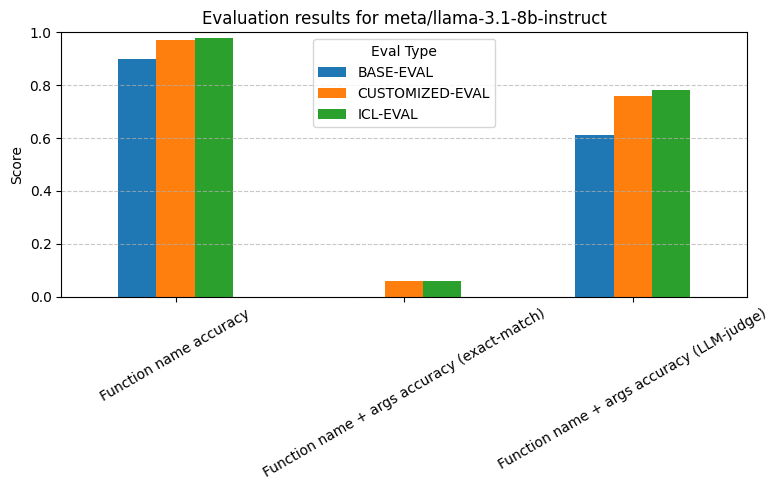

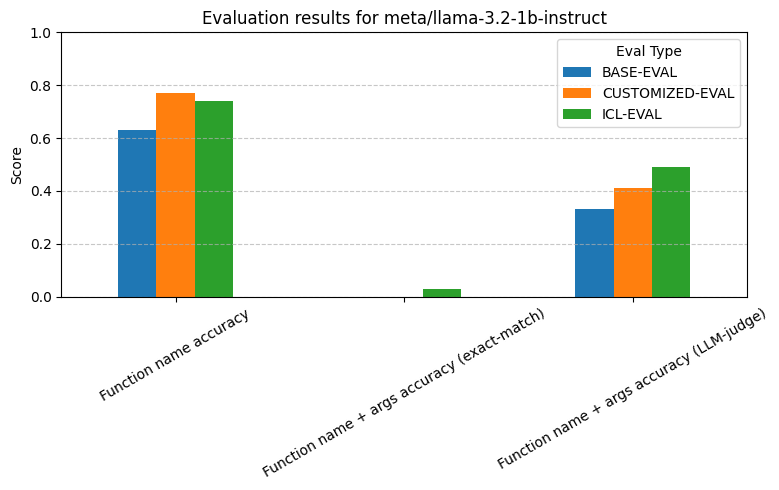

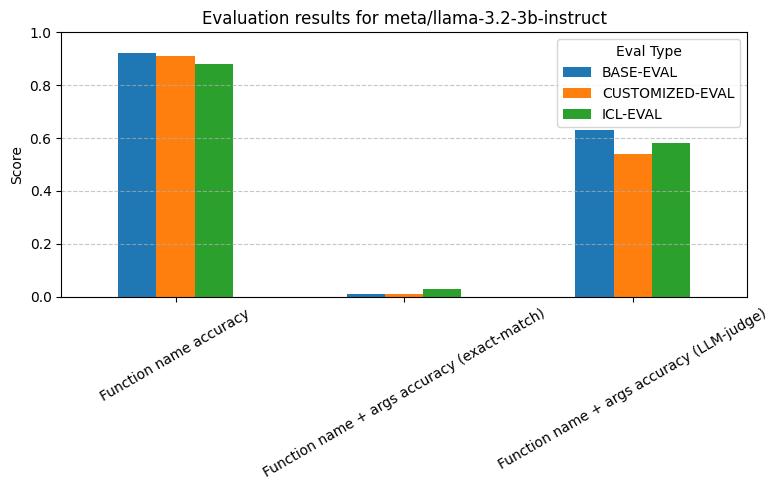

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [14]:
from notebooks.utils.job_monitor_helper import monitor_job

monitor_job(
    api_base_url=API_BASE_URL,
    job_id=job_id,
    poll_interval=5
) 

You’ve now successfully completed a Flywheel run and can review the evaluation results to decide whether to promote the customized or ICL model. However, with only 300 data points, the customized `Llama-3.2-1B-instruct` is likely still limited in accuracy.

That said, the Data Flywheel operates as a self-reinforcing cycle—models continue to improve as more user interaction logs are collected. Below, we demonstrate how the model accuracy improves incrementally with additional data.

---

## Step 4: Show Continuous Improvement (Optional)

To extend the flywheel run with additional data, we’ll launch a new job using `client_id` set to "aiva-2", which includes **500** data points, to evaluate the impact of increased data volume on performance.

Note that `client_id` is originally intended to identify the client that generated the traffic. However, in the notebook, it was repurposed to represent datasets of varying sizes, illustrating the progressive improvement of the data flywheel as more data is collected.

In [18]:
response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={"workload_id": "primary_assistant", "client_id": "aiva-2"}
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 6891b67a7d6218d157ba3542


Job Status: completed
Total Records: 500
Last Updated: 15:48:24

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,Function name accuracy,Function name + args accuracy (exact-match),Function name + args accuracy (LLM-judge)
6,meta/llama-3.1-8b-instruct,BASE-EVAL,100.0,7m 22s,Completed,08:23:06,08:30:27,0.91,0.01,0.58
8,meta/llama-3.1-8b-instruct,CUSTOMIZED-EVAL,100.0,6m 36s,Completed,08:32:07,08:38:43,0.98,0.05,0.77
7,meta/llama-3.1-8b-instruct,ICL-EVAL,100.0,7m 37s,Completed,08:23:06,08:30:42,0.91,0.01,0.58
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,8m 12s,Completed,07:48:43,07:56:55,0.54,0.00,0.28
2,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,6m 21s,Completed,07:55:14,08:01:35,0.95,0.06,0.70
1,meta/llama-3.2-1b-instruct,ICL-EVAL,100.0,7m 57s,Completed,07:48:43,07:56:39,0.53,0.00,0.24
3,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,7m 27s,Completed,08:05:02,08:12:29,0.86,0.03,0.56
5,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,6m 16s,Completed,08:13:33,08:19:49,0.89,0.03,0.67
4,meta/llama-3.2-3b-instruct,ICL-EVAL,100.0,7m 27s,Completed,08:05:02,08:12:29,0.86,0.03,0.57



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
2,meta/llama-3.1-8b-instruct,08:23:06,2,46,08:32:07,Completed,9m 1s,100.0
0,meta/llama-3.2-1b-instruct,07:48:43,2,46,07:55:14,Completed,6m 31s,100.0
1,meta/llama-3.2-3b-instruct,08:05:02,2,46,08:13:33,Completed,8m 31s,100.0


{'id': '6891b67a7d6218d157ba3542',
 'workload_id': 'primary_assistant',
 'client_id': 'aiva-2',
 'status': 'completed',
 'started_at': '2025-08-05T07:44:58.278000',
 'finished_at': '2025-08-05T08:39:44.614000',
 'num_records': 500,
 'llm_judge': {'model_name': 'nvdev/meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 998.26173,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'function_name': 0.54,
      'function_name_and_args_accuracy': 0.0,
      'tool_calling_correctness': 0.28},
     'started_at': '2025-08-05T07:48:43.638000',
     'finished_at': '2025-08-05T07:56:55.023000',
     'runtime_seconds': 492.133544,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-2hiSSjivxNhyh3TbAiEMp1',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/7927628481964

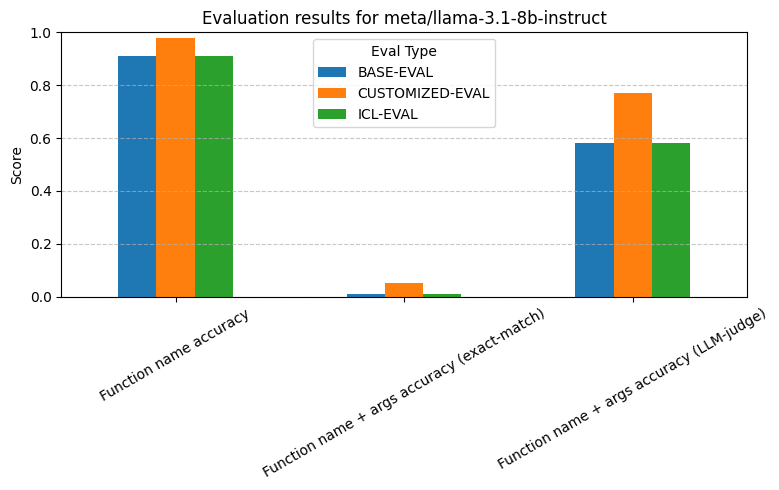

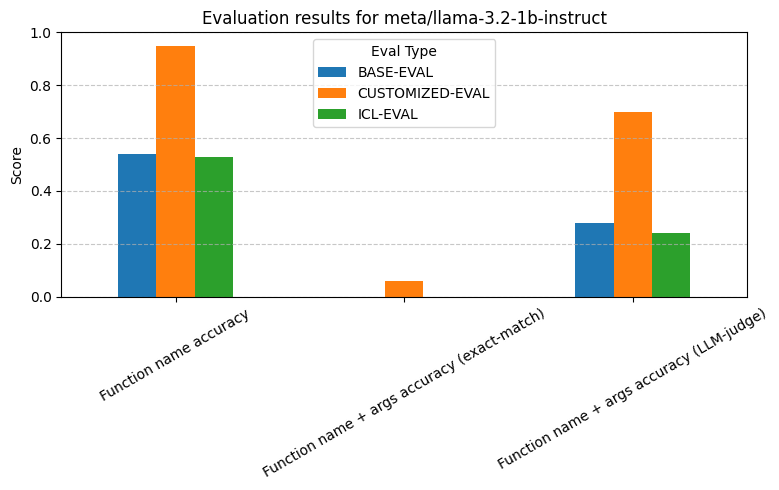

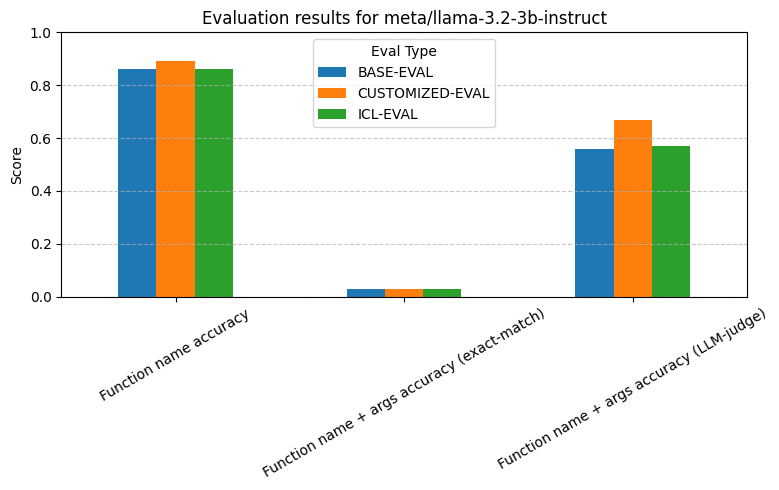

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [23]:
monitor_job(
    api_base_url=API_BASE_URL,
    job_id=job_id,
    poll_interval=5
) 

You should see some improvements of the customized model compared to the last run.

Assuming we have now collected even more data points, let's kick off another flywheel run by setting `client_id` to "aiva-3" which includes **1,000** records.

In [25]:
response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={"workload_id": "primary_assistant", "client_id": "aiva-3"}
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 6891c3597d6218d157ba3543


Job Status: completed
Total Records: 1000
Last Updated: 15:50:34

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,Function name accuracy,Function name + args accuracy (exact-match),Function name + args accuracy (LLM-judge)
6,meta/llama-3.1-8b-instruct,BASE-EVAL,100.0,7m 32s,Completed,09:25:51,09:33:22,0.89,0.02,0.57
8,meta/llama-3.1-8b-instruct,CUSTOMIZED-EVAL,100.0,6m 41s,Completed,09:39:53,09:46:34,0.97,0.03,0.82
7,meta/llama-3.1-8b-instruct,ICL-EVAL,100.0,7m 27s,Completed,09:25:51,09:33:17,0.91,0.02,0.65
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,7m 57s,Completed,08:43:33,08:51:29,0.56,0.01,0.23
2,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,5m 56s,Completed,08:53:04,08:59:00,0.99,0.00,0.67
1,meta/llama-3.2-1b-instruct,ICL-EVAL,100.0,8m 17s,Completed,08:43:33,08:51:49,0.59,0.01,0.23
3,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,7m 7s,Completed,09:02:27,09:09:33,0.90,0.02,0.63
5,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,6m 26s,Completed,09:15:28,09:21:54,0.96,0.08,0.80
4,meta/llama-3.2-3b-instruct,ICL-EVAL,100.0,7m 17s,Completed,09:02:27,09:09:43,0.90,0.02,0.65



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
2,meta/llama-3.1-8b-instruct,09:25:51,2,102,09:39:53,Completed,14m 1s,100.0
0,meta/llama-3.2-1b-instruct,08:43:33,2,102,08:53:04,Completed,9m 31s,100.0
1,meta/llama-3.2-3b-instruct,09:02:27,2,102,09:15:28,Completed,13m 1s,100.0


{'id': '6891c3597d6218d157ba3543',
 'workload_id': 'primary_assistant',
 'client_id': 'aiva-3',
 'status': 'completed',
 'started_at': '2025-08-05T08:39:53.117000',
 'finished_at': '2025-08-05T09:47:34.956000',
 'num_records': 1000,
 'llm_judge': {'model_name': 'nvdev/meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 1148.332232,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'function_name': 0.56,
      'function_name_and_args_accuracy': 0.01,
      'tool_calling_correctness': 0.23},
     'started_at': '2025-08-05T08:43:33.181000',
     'finished_at': '2025-08-05T08:51:29.600000',
     'runtime_seconds': 477.129951,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-VjazP2MgzkYxhs31nRudf5',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/517080148

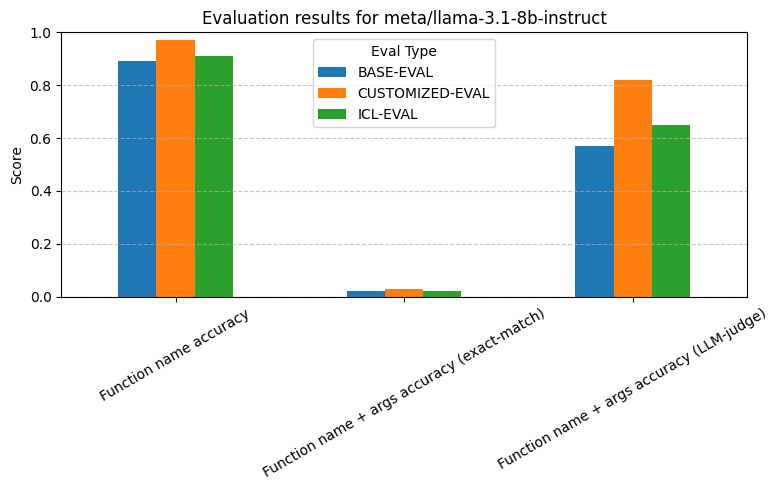

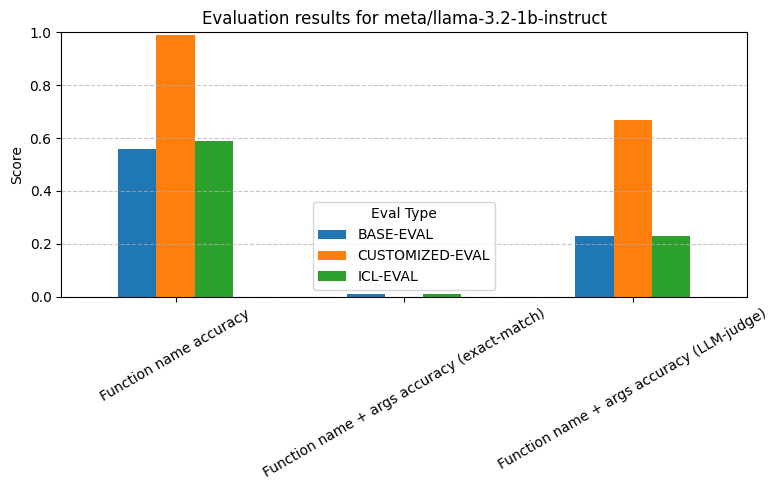

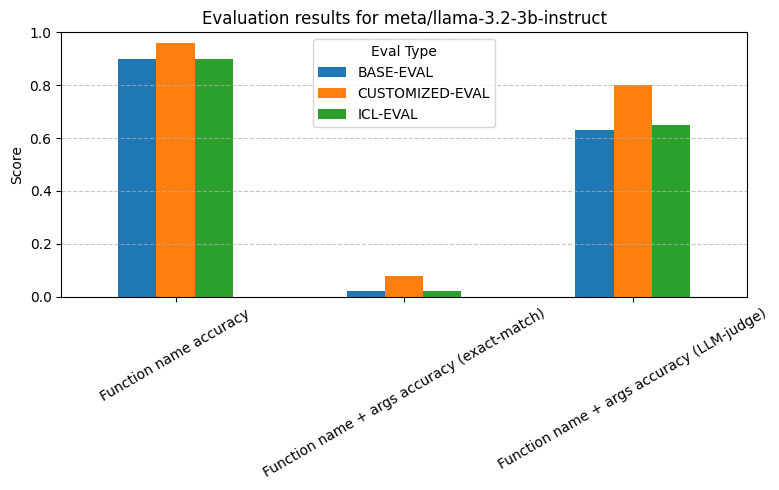

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [24]:
monitor_job(
    api_base_url=API_BASE_URL,
    job_id=job_id,
    poll_interval=5
) 

After the run with 1,000 data points, we should observe the customized model’s accuracies improving significantly, with the Function name accuracy approaching 1.0. 

This indicates that the customized `LLama-3.2-1B-instruct` model achieves accuracy comparable to the much larger `LLama-3.3-70B-instruct` base model deployed in AI Virtual Assistant, while significantly reducing latency and compute usage thanks to its smaller size. 

In the next step, we will show how to deploy the customized `LLama-3.2-1B-instruct` and run inference with it.

---

## Step 5: Deploy Customized Model and Run Inference

NeMo Microsevices Platform provides two component microservices to simplify model deployment and inference:

- NeMo Deployment Management: Provides an API to deploy NIM on a Kubernetes cluster and manage them through the NIM Operator microservice.
- NeMo NIM Proxy: Provides a unified endpoint that you can use to access all deployed NIM for inference tasks.

First, we need to deploy the base `LLama-3.2-1B-instruct` model:

In [29]:
url = "http://nemo.test/v1/deployment/model-deployments"  # if you used Launchable setup, then the base url will be http://nemo.test. Otherwise, change the base url accordingly.
headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}
payload = {
    "name": "llama-3.2-1b-instruct",
    "namespace": "meta",
    "config": {
        "model": "meta/llama-3.2-1b-instruct",
        "nim_deployment": {
            "image_name": "nvcr.io/nim/meta/llama-3.2-1b-instruct",
            "image_tag": "1.8",
            "pvc_size": "25Gi",
            "gpu": 1,
            "additional_envs": {
                "NIM_GUIDED_DECODING_BACKEND": "outlines"
            }
        }
    }
}

response = requests.post(url, headers=headers, json=payload)
print(response.status_code)
print(response.json())


200
{'async_enabled': False, 'config': {'model': 'meta/llama-3.2-1b-instruct', 'nim_deployment': {'additional_envs': {'NIM_GUIDED_DECODING_BACKEND': 'outlines'}, 'gpu': 1, 'image_name': 'nvcr.io/nim/meta/llama-3.2-1b-instruct', 'image_tag': '1.8'}}, 'created_at': '2025-08-05T20:27:04.681827245Z', 'deployed': False, 'name': 'llama-3.2-1b-instruct', 'namespace': 'meta', 'status_details': {'description': 'Model deployment created', 'status': 'pending'}, 'url': ''}


Next, we need to get the name of the fine-tuned model, which can be obtained from the job status API:

In [61]:
response = requests.get(f"{API_BASE_URL}/api/jobs/{job_id}")  # use the job_id for the best run based on eval results
ft_model_name = response.json()['nims'][0]['customizations'][0]['customized_model']

Now we can run inference with the fine-tuned model using the NIM Proxy service:
Note: Wait until the deployment is finished, it may take ~5 mins.

In [69]:
import random

# get a example input request for inference
with open(DATA_PATH, "r") as f:
    lines = f.readlines()
random_line = random.choice(lines)
input_data = json.loads(random_line)

url = "http://nim.test/v1/chat/completions"  # if you used Launchable setup, then the base url will be http://nim.test. Otherwise, change the base url accordingly.
headers = {
    "Content-Type": "application/json"
}
payload = {
    "model": ft_model_name,
    "messages": input_data['request']['messages'],
    "tools": input_data['request']['tools'],
    "stream": False
}

response = requests.post(url, headers=headers, json=payload)
response.json()['choices'][0]['message']

{'role': 'assistant',
 'content': None,
 'tool_calls': [{'id': 'chatcmpl-tool-c3943db79bdd44e09b93ce3a20fbc534',
   'type': 'function',
   'function': {'name': 'ToProductQAAssistant',
    'arguments': '{"query": "what colors are available for the Geforce Hat?"}'}}]}

Optionally, you can also download the LoRA adapters. In Nemo Microservices Platform, LoRA adapters are uploaded to NeMo Data Store after fine tuning. NeMo Data Store exposing APIs compatible with the Hugging Face Hub client which we can interact with to download the LoRA adapters.

In [46]:
from huggingface_hub import snapshot_download

DATA_STORE_ENDPOINT = "http://data-store.test"  # if you used Launchable setup, then the base url to NeMo Data Store will be http://data-store.test. Otherwise, change the base url accordingly.
MODEL_ID, CUSTOMIZATION_JOB_ID = ft_model_name.split('@', 1)

# Download the model
local_model_path = snapshot_download(
    repo_id=MODEL_ID,
    repo_type="model",
    revision=CUSTOMIZATION_JOB_ID,
    local_dir="./downloaded_loras",
    endpoint=f"{DATA_STORE_ENDPOINT}/v1/hf",
    force_download=True
)

print(f"Model downloaded to: {local_model_path}")

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 80.27it/s]

Model downloaded to: /home/ubuntu/data-flywheel/downloaded_loras


---

## Step 6: Expose the Customized Model for External Access (Brev Launchable Only)

To enable external access to the customized model, we first need to do local port forwarding:

In [78]:
import subprocess

# Forward local port 8080 to service port 8000
log_file = open("port_forward.log", "w")
pf_process = subprocess.Popen(
    ["kubectl", "port-forward", "svc/nemo-nim-proxy", "8080:8000"],
    stdout=log_file,
    stderr=log_file,
)

print(f"Port-forward started in background with PID {pf_process.pid}")

Port-forward started in background with PID 3835160


Next navigate to your Brev instance page, go to the `Access` tab, select `Using Secure Links`, find the link that looks like https://inference-*.brevlab.com, click the `Edit Access`, and toggle on `Make Public`.

Now you should be able to run inference with the above url externally:

In [80]:
url = "https://inference-16qlcb1wy.brevlab.com/v1/chat/completions"  # if you used Launchable setup, update the url according to the url from Brev instance page.

headers = {
    "Content-Type": "application/json"
}
payload = {
    "model": ft_model_name,
    "messages": input_data['request']['messages'],
    "tools": input_data['request']['tools'],
    "stream": False
}

response = requests.post(url, headers=headers, json=payload)
response.json()['choices'][0]['message']

{'role': 'assistant',
 'content': None,
 'tool_calls': [{'id': 'chatcmpl-tool-e8c71f8d75634481af6ee72596f82e1e',
   'type': 'function',
   'function': {'name': 'ToProductQAAssistant',
    'arguments': '{"query": "what colors are available for the Geforce Hat?"}'}}]}